In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
import torchvision.models as models
from torchvision.models import resnet18
from tqdm import tqdm
#from transformers import BertModel, BertConfig
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import torchvision.transforms
import torch.utils.data as data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.metrics import roc_auc_score,average_precision_score, precision_recall_curve
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm
import torch.utils.data as data
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
#from utils import *
import logging
from torch.utils.tensorboard import SummaryWriter

import os
import numpy as np
import argparse
import configparser




In [ ]:
import warnings
from skimage import io, transform
from rasterio.features import rasterize
from shapely.ops import cascaded_union, unary_union
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
import pickle
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
from pytorch_metric_learning import losses
import copy

import albumentations as A
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import timm
from torch.cuda import amp
from tqdm import tqdm
import torch.optim as optim
from time import time

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [ ]:
train_df = pd.read_csv(r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset\train.csv')
val_df = pd.read_csv(r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset\val.csv')
test_df = pd.read_csv(r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset\test.csv')

train_df.head()

In [ ]:
train_df_class = train_df.groupby(['merged_label']).size().to_frame('train').reset_index()
val_df_class = val_df.groupby(['merged_label']).size().to_frame('val').reset_index()
test_df_class = test_df.groupby(['merged_label']).size().to_frame('test').reset_index()

plt.figure(figsize=(8, 6))
x_axis = np.arange(len(train_df_class['merged_label']))
index = [[train_df_class,'train',-0.2],[val_df_class,'val',0],[test_df_class,'test',0.2]]
for i in index:
  df = i[0]
  bars = plt.bar(x_axis + i[2], df[i[1]] , width=0.2, label=i[1])
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x(), yval + .005, yval)
plt.xticks(x_axis,train_df_class['merged_label'])
plt.legend()
plt.show()

In [ ]:
class ForestDataset(Dataset):
    """Forest dataset."""

    def __init__(self, csv_file_to_df, root_dir=r'C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset', transform=None, types="classifier", device = device):
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_int = {'Grassland shrubland': torch.asarray([1,0,0,0]), 'Other': torch.asarray([0,1,0,0]), 'Plantation': torch.asarray([0,0,1,0]), 'Smallholder agriculture': torch.asarray([0,0,0,1])}
        self.types = types
        self.device =device

    def __len__(self):
        return len(self.csv)

    def poly_from_utm(self, polygon):
        poly_pts = []

        poly = unary_union(polygon)
        for i in np.array(poly.exterior.coords):

            poly_pts.append(tuple(i))

        new_poly = Polygon(poly_pts)
        return new_poly

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.csv.iloc[idx, 0]
        merged_label = self.csv.iloc[idx, 1]
        lat = self.csv.iloc[idx, 2]
        long = self.csv.iloc[idx, 3]
        year = self.csv.iloc[idx, 4]
        folder = self.csv.iloc[idx, 5]

        ## Load the image and auxiliary
        image = Image.open(f'{self.root_dir}/{folder}/images/visible/composite.png')#io.imread(f'{self.root_dir}/{folder}/images/visible/composite.png')
        image = self.transform(image)
        #slope = np.load(f'{self.root_dir}/{folder}/auxiliary/slope.npy')

        ## Get the segmentation map
        with open(f'{self.root_dir}/{folder}/forest_loss_region.pkl', 'rb') as f:
            data = pickle.load(f)

        nx, ny = 332, 332
        xy_array = np.empty((0,2))
        if data.geom_type == 'Polygon':
            data = [data]
        elif data.geom_type == 'Multipolygon':
            data = list(data)

        poly_shp = []
        for poly_verts in data:
            poly_shp.append(self.poly_from_utm(poly_verts))

        mask = rasterize(shapes=poly_shp, out_shape=(332,332))
        seg = np.array(mask)

        '''
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        '''


        image = image.to(self.device, dtype=torch.float32)#torch.from_numpy(image).to(self.device, dtype=torch.float32)
        #image = image.permute(2, 0, 1)
        seg = torch.from_numpy(seg).to(self.device, dtype=torch.float32)
        #slope = torch.from_numpy(slope).type(torch.float)

        two_channel_seg = torch.zeros((2, seg.shape[0], seg.shape[1]), dtype=torch.float).to(self.device, dtype=torch.float32)

        # 将单通道掩码映射到两个通道
        two_channel_seg[0, :, :] = (seg == 0).float()  # 耕地的像素设为第一个通道的值
        two_channel_seg[1, :, :] = (seg == 1).float()  # 森林的像素设为第二个通道的值


        merged_label = self.label_to_int[merged_label]

        merged_label = merged_label.to(self.device, dtype=torch.float32)



        #image = image[:, 86:246, 86:246]
        seg = two_channel_seg[:, 52:276, 52:276]#seg[86:246, 86:246]
        #slope = slope[86:246, 86:246]
        if self.types == "classifier":
            return image, merged_label, seg
        else:
            return image, merged_label, seg

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
])

In [ ]:
a = np.load(r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\ForestNetDataset\examples\-0.002226324002905_109.97159881327198\auxiliary\srtm.npy")
plt.imshow(a.transpose(1,2,0))

In [ ]:
import torch.multiprocessing as mp

# 设置 multiprocessing 启动方法为 'spawn'
mp.set_start_method('spawn', force=True)


In [ ]:
def f_score(gt,pr, beta=1, eps=1e-7, threshold=None, activation="None"):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """



    '''
    if threshold is not None:
        pr = (pr > threshold).float()
    '''

    beta = 1
    gt = torch.argmax(gt, dim =1).float()
    pr = torch.argmax(pr, dim = 1).float()
    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return 1 - score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self,y_gt, y_pr):
        return 1 - f_score(y_pr, y_gt, beta=1.,
                           eps=self.eps, threshold=None,
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='None', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.CrossEntropyLoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_gt, y_pr):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce), dice

In [ ]:
def f1_loss(labels, outputs):
    # 计算True Positives (TP)、False Positives (FP)和False Negatives (FN)
    TP = torch.sum(outputs[:, 1] * labels[:, 1])  # True Positives
    FP = torch.sum(outputs[:, 1] * (1 - labels[:, 1]))  # False Positives
    FN = torch.sum((1 - outputs[:, 1]) * labels[:, 1])  # False Negatives

    # 计算精确度 (Precision) 和召回率 (Recall)
    precision = TP / (TP + FP + 1e-6)  # Precision
    recall = TP / (TP + FN + 1e-6)  # Recall

    # 计算F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)  # F1 Score

    # 计算F1 Loss
    f1_loss = 1 - f1  # F1 Loss

    return f1_loss

In [ ]:
SMOOTH = 1e-6

def iou_pytorch(labels, outputs):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = torch.argmax(outputs, dim=1).squeeze(1)
    labels = torch.argmax(labels, dim=1).squeeze(1)


    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return 1 - iou.mean()


In [ ]:
# Currently Not Used

#from transformers import Mask2FormerConfig, AutoImageProcessor, Mask2FormerForUniversalSegmentation
import torchvision.models
vgg16 = torchvision.models.vgg16(pretrained=True).to(device).features[:29]
vgg16.eval()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 256
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nbClass = 4

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoder, self).__init__()

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=4),  # 上采样
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=4, padding=0),  # 上采样操作
            nn.Softmax2d()
        )

    def forward(self, x):
        # 解码器部分
        output = self.decoder(x)
        return output

# 创建模型
in_channels = 512
out_channels = 2
decoder = UNetDecoder(in_channels, out_channels).to(device)

optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3) #, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)


number_of_epochs = 100

best_val_loss = float('inf')

runs = "total_run"

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    for i, (images, labels, seg) in enumerate(pbar):

      #Feature_Extraction_Model.eval()
      #inputs = processor(images=images, return_tensors="pt")
      vgg16.eval()
      with torch.no_grad():
          outputs = vgg16(images)

      #upsampled_features = outputs#.pixel_decoder_last_hidden_state

      optimizer.zero_grad()

      output_final = decoder(outputs)

      loss = criterion(seg.type(torch.float32), output_final.type(torch.float32))

      tp = f1_loss(seg, output_final) #iou_pytorch(seg, output_final)
      iou = iou_pytorch(seg, output_final)

      loss = loss+tp

      pbar.set_postfix(Train_Loss=loss.item(), Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss

      loss.backward()

      optimizer.step()

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        for i, (images, labels, seg) in enumerate(pbar):

            #Feature_Extraction_Model.eval()
            #inputs = processor(images=images, return_tensors="pt")
            vgg16.eval()
            with torch.no_grad():
                outputs = vgg16(images)

            #upsampled_features = outputs#.pixel_decoder_last_hidden_state


            output_final = decoder(outputs)

            loss = criterion(seg.type(torch.float32), output_final.type(torch.float32))
            tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)
            iou = iou_pytorch(seg, output_final)

            loss = loss+tp

            pbar.set_postfix(Val_Loss=loss.item(), VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss

            if val_loss < best_val_loss:

                best_val_loss = val_loss
                torch.save(decoder.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt.pt"))

        plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    scheduler.step()




In [ ]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

model = UNet(n_channels=3, n_classes=2).to(device)

In [ ]:
model

In [ ]:
# For Segmentation

from sklearn.metrics import f1_score

import timm
import torch
import torch.nn as nn

# 定义分割模型
class SegmentationModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(SegmentationModel, self).__init__()
        # 创建timm模型
        model = timm.create_model(model_name, pretrained=True)

        # 去除最后的全局平均池化层和全连接层
        self.backbone = nn.Sequential(*list(model.children())[:-2])

        # 获取num_features
        num_features = model.layer4[2].conv3.out_channels

        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(num_features, 512, kernel_size=7, padding=3, output_padding=0, stride=4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, num_classes, kernel_size=8, padding=3, output_padding=0, stride=2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.segmentation_head(x)
        return x

# 指定模型名称和类别数
model_name = 'resnet50'  # 选择适合你任务的模型，可以根据需要更改
num_classes = 2  # 类别数为2

# 创建分割模型
#segmentation_model = SegmentationModel(model_name, num_classes).to(device)



os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 4
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



number_of_epochs = 1000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")

#ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_for_seg_new_2_tr.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

#checkpoint = torch.load(ckpt_for_tr)

#cls_model.load_state_dict(checkpoint['model_state_dict'])

#cls_model.train()

#model_vit.load_state_dict(checkpoint['model_state_dict'])

#segmentation_model.load_state_dict(checkpoint['model_state_dict'])


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.MSELoss() #nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

#scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 51, eta_min=0, last_epoch=-1, verbose=False)


#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

MSE_list = list()

F1_list =list()

IOU_list = list()



for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    acc = 0
    model.train()

    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      outputs = model(images)#(images, output_seg)#(output_final)

      loss = criterion(seg, outputs)

      outputs = torch.nn.functional.softmax(outputs, dim = 1)


      tp = f1_loss(seg, outputs) #iou_pytorch(seg, output_final)

      iou = iou_pytorch(seg, outputs)

      #loss = loss+tp

      MSE_list.append(loss.item)

      F1_list.append(tp.item())

      IOU_list.append(iou.item())

      pbar.set_postfix(Train_Loss=loss.item(), Train_F1_Loss = tp.item(), IOU =iou.item())#, Train_Accuracy = accuracy, Train_F1_Score = f1)#, Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss



      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0

        #cls_model.eval()

        model.eval()

        for i, (images, labels, seg) in enumerate(pbar):


            outputs = model(images)#(images, output_seg)#(output_final)

            loss = criterion(seg, outputs)

            outputs = torch.nn.functional.softmax(outputs, dim = 1)

            tp = f1_loss(seg, outputs)#iou_pytorch(seg, output_final)

            iou = iou_pytorch(seg, outputs)

            #loss = loss+tp

            pbar.set_postfix(Val_Loss=loss.item(), VAL_F1_Loss = tp.item(), IOU = iou.item())#, Val_Accuracy = accuracy, Val_F1_Score = f1) #, VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss



            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint_vit = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint_vit, os.path.join("Model_Ckpts",runs+f"ckpt_test_for_seg_new_21_12.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))



        print("###### Epoch: ", epoch,"_",val_acc_mean/15," ######")
        #plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    scheduler.step()




In [ ]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)

        x = self.mlp_head(x)

        #x= self.softmax(x)
        return x #torch.sigmoid(x)

model_vit = ViT(
    image_size=(224, 224),
    patch_size=(16, 16),
    num_classes=4,  # 输出类别数
    dim=128,         # 模型维度
    depth=6,         # Transformer层的深度
    heads=8,         # 注意力头的数量
    mlp_dim=256,     # MLP的隐藏层维度
    pool='cls',      # 池化方式，可以是'cls'或'mean'
    channels=3,  # 输入图像通道数
    dim_head=64,     # 注意力头的维度
    dropout=0,     # Dropout概率
    emb_dropout=0  # 嵌入层的Dropout概率
).to(device)

In [ ]:
# For Drivers Classification

from sklearn.metrics import f1_score


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")

ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_less_lr_model_optimizer_scheduler_checkpoint_new.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

checkpoint = torch.load(ckpt_for_tr)

#cls_model.load_state_dict(checkpoint['model_state_dict'])

#cls_model.train()

#model_vit.load_state_dict(checkpoint['model_state_dict'])



optimizer = torch.optim.Adam(model_vit.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 51, eta_min=0, last_epoch=-1, verbose=False)


#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

Total_Cross_Entropy_List =list()

Total_Accuracy_List = list()

Total_F1_Score_List = list()

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    acc = 0
    model_vit.train()

    Cross_Entropy_List =list()

    Accuracy_List = list()

    F1_Score_List = list()

    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      zero_input = torch.empty(seg.shape[0], 1, seg.shape[2], seg.shape[-1])

      add_zero = torch.zeros_like(zero_input).to(device)

      output_seg = torch.concat((seg, add_zero), dim = 1)

      output_final = images #+ output_seg

      outputs = model_vit(output_final)#(images, output_seg)#(output_final)

      loss = criterion(labels, outputs)

      #tp = f1_loss(seg, output_final) #iou_pytorch(seg, output_final)

      #iou = iou_pytorch(seg, output_final)

      #loss = loss+tp
      outputs = torch.nn.functional.softmax(outputs, dim = -1)
      outputs = torch.argmax(outputs,dim= -1).squeeze()
      labels = torch.argmax(labels,dim= -1).squeeze()

      correct = (outputs == labels).sum().item()


      total = labels.size(0)


      accuracy = correct / total

      f1 = f1_score(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy(), average='macro')

      pbar.set_postfix(Train_Loss=loss.item(), Train_Accuracy = accuracy, Train_F1_Score = f1)#, Train_F1_Loss = tp.item(), IOU =iou.item())

      Cross_Entropy_List.append(loss.item())

      Accuracy_List.append(accuracy)

      F1_Score_List.append(f1)

      train_loss += loss



      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    Total_Cross_Entropy_List.append(np.array(Cross_Entropy_List).mean())

    Total_Accuracy_List.append(np.array(Accuracy_List).mean())

    Total_F1_Score_List.append(np.array(F1_Score_List).mean())

    print(len(Total_Cross_Entropy_List))

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0

        #cls_model.eval()

        model_vit.eval()

        for i, (images, labels, seg) in enumerate(pbar):

            zero_input = torch.empty(seg.shape[0], 1, seg.shape[2], seg.shape[-1])

            add_zero = torch.zeros_like(zero_input).to(device)

            output_seg = torch.concat((seg, add_zero), dim = 1)

            output_final = images #+ output_seg

            outputs = model_vit(output_final)#(images, output_seg)#(output_final)

            loss = criterion(labels, outputs)

            #tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)

            #iou = iou_pytorch(seg, output_final)

            #loss = loss+tp

            outputs = torch.nn.functional.softmax(outputs, dim = -1)

            outputs = torch.argmax(outputs,dim=-1).squeeze()
            labels = torch.argmax(labels,dim=-1).squeeze()

            correct = (outputs == labels).sum().item()


            total = labels.size(0)



            accuracy = correct / total

            f1 = f1_score(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy(), average='macro')

            pbar.set_postfix(Val_Loss=loss.item(), Val_Accuracy = accuracy, Val_F1_Score = f1) #, VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss

            val_acc_mean += accuracy


            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint_vit = {
                                'model_state_dict': model_vit.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint_vit, os.path.join("Model_Ckpts",runs+f"ckpt_test_less_lr_model_optimizer_scheduler_1221_plain_VIT.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))



        print("###### Epoch: ", epoch,"_",val_acc_mean/15," ######")
        #plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    scheduler.step()




In [25]:
len(F1_Score_List)

6

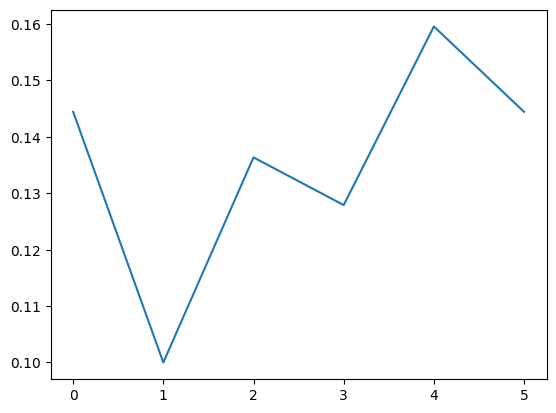

In [26]:
plt.plot(F1_Score_List)

In [ ]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim_q=160, dim_k=160, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inner_dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm_q = nn.LayerNorm(dim_q)
        self.norm_k = nn.LayerNorm(dim_k)

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_q = nn.Linear(dim_q, inner_dim, bias=False)
        self.to_k = nn.Linear(dim_k, inner_dim, bias=False)
        self.to_v = nn.Linear(dim_k, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim_q),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, q, k):
        q = self.norm_q(q)
        k = self.norm_k(k)

        q, k, v = self.to_q(q), self.to_k(k), self.to_v(k)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)


class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, img, info):
        x = self.to_patch_embedding(img)
        x_k = info
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x, x_k)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)

        x = self.mlp_head(x)

        x= self.softmax(x)
        return x #torch.sigmoid(x)

model_vit = ViT(
    image_size=(160, 160),
    patch_size=(16, 16),
    num_classes=3,  # 输出类别数
    dim=128,         # 模型维度
    depth=6,         # Transformer层的深度
    heads=8,         # 注意力头的数量
    mlp_dim=256,     # MLP的隐藏层维度
    pool='cls',      # 池化方式，可以是'cls'或'mean'
    channels=3,  # 输入图像通道数
    dim_head=64,     # 注意力头的维度
    dropout=0,     # Dropout概率
    emb_dropout=0  # 嵌入层的Dropout概率
).to(device)

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim_q, dim_k, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inner_dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm_q = nn.LayerNorm(dim_q)
        self.norm_k = nn.LayerNorm(dim_k)

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_q = nn.Linear(dim_q, inner_dim, bias=False)
        self.to_k = nn.Linear(dim_k, inner_dim, bias=False)
        self.to_v = nn.Linear(dim_k, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim_q),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, q, k):
        q = self.norm_q(q)
        k = self.norm_k(k)

        q, k, v = self.to_q(q), self.to_k(k), self.to_v(k)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        return self.to_out(out)


In [ ]:
import torch
import torch.nn as nn

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()

        # 第一个卷积层
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 第二个卷积层
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 全连接层
        self.fc1 = nn.Linear(32 * 40 * 40, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)  # 4 是输出类别数量
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # 展平

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x= self.softmax(x)

        return x

# 创建模型实例
cls_model = CNNClassifier().to(device)



# 输出形状为 (batch_size, 4)，表示每个样本对应的类别分数


In [ ]:
import torch.nn as nn
import torchvision.models as models

class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)

        # 修改第一个卷积层以适应5个输入通道
        self.resnet50.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # 更新最后一层以适应你的任务
        self.resnet50.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        return self.resnet50(x)

# 创建一个输入通道为5，输出类别为num_classes的模型
num_classes = 4  # 替换为你的类别数量
cls_model = ModifiedResNet50(num_classes)

cls_model = nn.Sequential(
    cls_model,
    nn.Softmax(dim = 1)  # 添加 sigmoid 层
).to(device)




In [ ]:
import torch.nn as nn
import timm

# 使用 timm 创建一个预训练的 ResNet-18 模型
cls_model = timm.create_model('resnet50', pretrained=True)

# 获取原始模型的分类器中的输入特征数
num_ftrs = cls_model.get_classifier().in_features

# 修改模型的第一层卷积层，将输入通道数从3更改为5
cls_model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

# 修改模型的全连接层，以适应你的任务（这里假设输出类别数为4）
cls_model.fc = nn.Linear(num_ftrs, 4)

cls_model = nn.Sequential(
    cls_model,
    nn.Softmax(dim = 1)  # 添加 sigmoid 层
).to(device)

cls_model = cls_model.to(device)



In [ ]:
timm.list_models()

In [ ]:
import timm
import torch

# 指定模型名称和预训练权重
model_name = 'mobilevitv2_050' #'vit_base_patch16_224'  # 选择适合你任务的模型
pretrained = True  # 使用预训练权重

# 创建ViT模型
timm_vit_model = timm.create_model(model_name, pretrained=pretrained, num_classes=4).to(device)

In [ ]:
# For Drivers Classification

from sklearn.metrics import f1_score


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")

ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_less_lr_model_optimizer_scheduler_checkpoint_new.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

checkpoint = torch.load(ckpt_for_tr)

#cls_model.load_state_dict(checkpoint['model_state_dict'])

#cls_model.train()

#model_vit.load_state_dict(checkpoint['model_state_dict'])



optimizer = torch.optim.Adam(timm_vit_model.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 51, eta_min=0, last_epoch=-1, verbose=False)


#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    acc = 0
    timm_vit_model.train()

    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      zero_input = torch.empty(seg.shape[0], 1, seg.shape[2], seg.shape[-1])

      add_zero = torch.zeros_like(zero_input).to(device)

      output_seg = torch.concat((seg, add_zero), dim = 1)

      output_final = images #+ output_seg

      outputs = timm_vit_model(output_final)#(images, output_seg)#(output_final)

      loss = criterion(labels, outputs)

      #tp = f1_loss(seg, output_final) #iou_pytorch(seg, output_final)

      #iou = iou_pytorch(seg, output_final)

      #loss = loss+tp
      outputs = torch.nn.functional.softmax(outputs, dim = -1)
      outputs = torch.argmax(outputs,dim= -1).squeeze()
      labels = torch.argmax(labels,dim= -1).squeeze()

      correct = (outputs == labels).sum().item()


      total = labels.size(0)


      accuracy = correct / total

      f1 = f1_score(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy(), average='macro')

      pbar.set_postfix(Train_Loss=loss.item(), Train_Accuracy = accuracy, Train_F1_Score = f1)#, Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss



      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0

        #cls_model.eval()

        timm_vit_model.eval()

        for i, (images, labels, seg) in enumerate(pbar):

            zero_input = torch.empty(seg.shape[0], 1, seg.shape[2], seg.shape[-1])

            add_zero = torch.zeros_like(zero_input).to(device)

            output_seg = torch.concat((seg, add_zero), dim = 1)

            output_final = images #+ output_seg

            outputs = timm_vit_model(output_final)#(images, output_seg)#(output_final)

            loss = criterion(labels, outputs)

            #tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)

            #iou = iou_pytorch(seg, output_final)

            #loss = loss+tp

            outputs = torch.nn.functional.softmax(outputs, dim = -1)

            outputs = torch.argmax(outputs,dim=-1).squeeze()
            labels = torch.argmax(labels,dim=-1).squeeze()

            correct = (outputs == labels).sum().item()


            total = labels.size(0)



            accuracy = correct / total

            f1 = f1_score(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy(), average='macro')

            pbar.set_postfix(Val_Loss=loss.item(), Val_Accuracy = accuracy, Val_F1_Score = f1) #, VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss

            val_acc_mean += accuracy


            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint_vit = {
                                'model_state_dict': timm_vit_model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint_vit, os.path.join("Model_Ckpts",runs+f"ckpt_test_less_lr_model_optimizer_scheduler_checkpoint_new_seperate_img_and_seg.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))



        print("###### Epoch: ", epoch,"_",val_acc_mean/15," ######")
        #plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    scheduler.step()




In [ ]:
# For Segmentation

from sklearn.metrics import f1_score

import timm
import torch
import torch.nn as nn

# 定义分割模型
class SegmentationModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(SegmentationModel, self).__init__()
        # 创建timm模型
        model = timm.create_model(model_name, pretrained=True)

        # 去除最后的全局平均池化层和全连接层
        self.backbone = nn.Sequential(*list(model.children())[:-2])

        # 获取num_features
        num_features = model.layer4[2].conv3.out_channels

        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(num_features, 512, kernel_size=7, padding=3, output_padding=0, stride=4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, num_classes, kernel_size=8, padding=3, output_padding=0, stride=2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.segmentation_head(x)
        return x

# 指定模型名称和类别数
model_name = 'resnet50'  # 选择适合你任务的模型，可以根据需要更改
num_classes = 2  # 类别数为2

# 创建分割模型
segmentation_model = SegmentationModel(model_name, num_classes).to(device)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")

ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_for_seg_new_2_tr.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

checkpoint = torch.load(ckpt_for_tr)

#cls_model.load_state_dict(checkpoint['model_state_dict'])

#cls_model.train()

#model_vit.load_state_dict(checkpoint['model_state_dict'])

segmentation_model.load_state_dict(checkpoint['model_state_dict'])


optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.MSELoss() #nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 51, eta_min=0, last_epoch=-1, verbose=False)


#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

for epoch in range(number_of_epochs):

    pbar = tqdm(valloader)
    train_loss = 0
    acc = 0
    segmentation_model.train()

    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      outputs = segmentation_model(images)#(images, output_seg)#(output_final)

      loss = criterion(seg, outputs)

      outputs = torch.nn.functional.softmax(outputs, dim = 1)


      tp = f1_loss(seg, outputs) #iou_pytorch(seg, output_final)

      iou = iou_pytorch(seg, outputs)

      #loss = loss+tp


      pbar.set_postfix(Train_Loss=loss.item(), Train_F1_Loss = tp.item(), IOU =iou.item())#, Train_Accuracy = accuracy, Train_F1_Score = f1)#, Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss



      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0

        #cls_model.eval()

        segmentation_model.eval()

        for i, (images, labels, seg) in enumerate(pbar):


            outputs = segmentation_model(images)#(images, output_seg)#(output_final)

            loss = criterion(seg, outputs)

            outputs = torch.nn.functional.softmax(outputs, dim = 1)

            tp = f1_loss(seg, outputs)#iou_pytorch(seg, output_final)

            iou = iou_pytorch(seg, outputs)

            #loss = loss+tp

            pbar.set_postfix(Val_Loss=loss.item(), VAL_F1_Loss = tp.item(), IOU = iou.item())#, Val_Accuracy = accuracy, Val_F1_Score = f1) #, VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss



            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint_vit = {
                                'model_state_dict': segmentation_model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint_vit, os.path.join("Model_Ckpts",runs+f"ckpt_test_for_seg_new_2_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))



        print("###### Epoch: ", epoch,"_",val_acc_mean/15," ######")
        #plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    scheduler.step()




In [ ]:
# For Segmentation

from sklearn.metrics import f1_score

import timm
import torch
import torch.nn as nn

# 定义分割模型
class SegmentationModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(SegmentationModel, self).__init__()
        # 创建timm模型
        model = timm.create_model(model_name, pretrained=True)

        # 去除最后的全局平均池化层和全连接层
        self.backbone = nn.Sequential(*list(model.children())[:-2])

        # 获取num_features
        num_features = model.layer4[2].conv3.out_channels

        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(num_features, 512, kernel_size=7, padding=3, output_padding=0, stride=4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=8, padding=1, output_padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, num_classes, kernel_size=8, padding=3, output_padding=0, stride=2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.segmentation_head(x)
        return x

# 指定模型名称和类别数
model_name = 'resnet50'  # 选择适合你任务的模型，可以根据需要更改
num_classes = 2  # 类别数为2

# 创建分割模型
segmentation_model = SegmentationModel(model_name, num_classes).to(device)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")

ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_for_seg_new_2_tr.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

checkpoint = torch.load(ckpt_for_tr)

#cls_model.load_state_dict(checkpoint['model_state_dict'])

#cls_model.train()

#model_vit.load_state_dict(checkpoint['model_state_dict'])

segmentation_model.load_state_dict(checkpoint['model_state_dict'])


optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.MSELoss() #nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

segmentation_model.eval()

with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0

        #cls_model.eval()



        for i, (images, labels, seg) in enumerate(pbar):
            outputs = segmentation_model(images)#(images, output_seg)#(output_final)

            loss = criterion(seg, outputs)

            outputs = torch.nn.functional.softmax(outputs, dim = 1)

            tp = f1_loss(seg, outputs)#iou_pytorch(seg, output_final)

            iou = iou_pytorch(seg, outputs)

            #loss = loss+tp

            pbar.set_postfix(Val_Loss=loss.item(), VAL_F1_Loss = tp.item(), IOU = iou.item())#, Val_Accuracy = accuracy, Val_F1_Score = f1) #, VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss


In [ ]:
seg_real = torch.argmax(seg, dim = 1)
outputs_real = torch.argmax(outputs, dim=1)

for i in range(seg_real.shape[0]):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(seg_real[i].detach().cpu().numpy())
    plt.subplot(1, 2, 2)
    plt.imshow(outputs_real[i].detach().cpu().numpy())

    plt.figure()

In [ ]:
# For Drivers Classification

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")

ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_less_lr_model_optimizer_scheduler_checkpoint_new.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

checkpoint = torch.load(ckpt_for_tr)

#cls_model.load_state_dict(checkpoint['model_state_dict'])

#cls_model.train()

#model_vit.load_state_dict(checkpoint['model_state_dict'])



optimizer = torch.optim.Adam(model_vit.parameters(), lr=1e-4)#, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 51, eta_min=0, last_epoch=-1, verbose=False)


#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    acc = 0
    model_vit.train()

    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      zero_input = torch.empty(seg.shape[0], 1, seg.shape[2], seg.shape[-1])

      add_zero = torch.zeros_like(zero_input).to(device)

      output_seg = torch.concat((seg, add_zero), dim = 1)

      output_final = images + output_seg

      outputs = model_vit(images)#(images, output_seg)#(output_final)

      loss = criterion(labels, outputs)

      #tp = f1_loss(seg, output_final) #iou_pytorch(seg, output_final)

      #iou = iou_pytorch(seg, output_final)

      #loss = loss+tp

      outputs = torch.argmax(outputs,dim=-1).squeeze()
      labels = torch.argmax(labels,dim=-1).squeeze()

      correct = (outputs == labels).sum().item()


      total = labels.size(0)


      accuracy = correct / total

      pbar.set_postfix(Train_Loss=loss.item(), Train_Accuracy = accuracy)#, Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss



      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0

        #cls_model.eval()

        model_vit.eval()

        for i, (images, labels, seg) in enumerate(pbar):

            zero_input = torch.empty(seg.shape[0], 1, seg.shape[2], seg.shape[-1])

            add_zero = torch.zeros_like(zero_input).to(device)

            output_seg = torch.concat((seg, add_zero), dim = 1)

            output_final = images + output_seg

            outputs = model_vit(images)#(images, output_seg)#(output_final)

            loss = criterion(labels, outputs)

            #tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)

            #iou = iou_pytorch(seg, output_final)

            #loss = loss+tp

            outputs = torch.argmax(outputs,dim=-1).squeeze()
            labels = torch.argmax(labels,dim=-1).squeeze()

            correct = (outputs == labels).sum().item()


            total = labels.size(0)



            accuracy = correct / total

            pbar.set_postfix(Val_Loss=loss.item(), Val_Accuracy = accuracy)#, VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss

            val_acc_mean += accuracy


            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint_vit = {
                                'model_state_dict': model_vit.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),}
                                #'scheduler_state_dict': scheduler.state_dict()
                                                                                #}


                torch.save(checkpoint_vit, os.path.join("Model_Ckpts",runs+f"ckpt_test_less_lr_model_optimizer_scheduler_checkpoint_new_seperate.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))



        print("###### Epoch: ", epoch,"_",val_acc_mean/15," ######")
        #plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    #scheduler.step()




In [ ]:
# For Drivers Classification

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")

ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_less_lr_model_optimizer_scheduler_checkpoint_new.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

checkpoint = torch.load(ckpt_for_tr)

#cls_model.load_state_dict(checkpoint['model_state_dict'])

#cls_model.train()

#model_vit.load_state_dict(checkpoint['model_state_dict'])



optimizer = torch.optim.Adam(model_vit.parameters(), lr=1e-4)#, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 51, eta_min=0, last_epoch=-1, verbose=False)


#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    acc = 0
    model_vit.train()

    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      zero_input = torch.empty(seg.shape[0], 1, seg.shape[2], seg.shape[-1])

      add_zero = torch.zeros_like(zero_input).to(device)

      output_seg = torch.concat((seg, add_zero), dim = 1)

      output_final = images + output_seg

      outputs = model_vit(images)#(images, output_seg)#(output_final)

      loss = criterion(labels, outputs)

      #tp = f1_loss(seg, output_final) #iou_pytorch(seg, output_final)

      #iou = iou_pytorch(seg, output_final)

      #loss = loss+tp

      outputs = torch.argmax(outputs,dim=-1).squeeze()
      labels = torch.argmax(labels,dim=-1).squeeze()

      correct = (outputs == labels).sum().item()


      total = labels.size(0)


      accuracy = correct / total

      pbar.set_postfix(Train_Loss=loss.item(), Train_Accuracy = accuracy)#, Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss



      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0

        #cls_model.eval()

        model_vit.eval()

        for i, (images, labels, seg) in enumerate(pbar):

            zero_input = torch.empty(seg.shape[0], 1, seg.shape[2], seg.shape[-1])

            add_zero = torch.zeros_like(zero_input).to(device)

            output_seg = torch.concat((seg, add_zero), dim = 1)

            output_final = images + output_seg

            outputs = model_vit(images)#(images, output_seg)#(output_final)

            loss = criterion(labels, outputs)

            #tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)

            #iou = iou_pytorch(seg, output_final)

            #loss = loss+tp

            outputs = torch.argmax(outputs,dim=-1).squeeze()
            labels = torch.argmax(labels,dim=-1).squeeze()

            correct = (outputs == labels).sum().item()


            total = labels.size(0)



            accuracy = correct / total

            pbar.set_postfix(Val_Loss=loss.item(), Val_Accuracy = accuracy)#, VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss

            val_acc_mean += accuracy


            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint_vit = {
                                'model_state_dict': model_vit.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),}
                                #'scheduler_state_dict': scheduler.state_dict()
                                                                                #}


                torch.save(checkpoint_vit, os.path.join("Model_Ckpts",runs+f"ckpt_test_less_lr_model_optimizer_scheduler_checkpoint_new_seperate.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))



        print("###### Epoch: ", epoch,"_",val_acc_mean/15," ######")
        #plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    #scheduler.step()




In [ ]:
# For Drivers Classification

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

pretrained_resnet_18 = timm.create_model('resnet18', pretrained=True)
num_ftrs = pretrained_resnet_18.get_classifier().in_features
pretrained_resnet_18.fc = nn.Linear(num_ftrs, 4)
pretrained_resnet_18 = nn.Sequential(
    pretrained_resnet_18,
    nn.Softmax(dim=1)  # 在第一维度（列）上应用softmax
)

pretrained_resnet_18 = pretrained_resnet_18.to(device)

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



#seg_optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)#, weight_decay=1e-5)
#seg_criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()
#seg_scheduler = torch.optim.lr_scheduler.MultiStepLR(seg_optimizer, milestones=[100,200,300,500], gamma=0.1)




number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")


#ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_less_lr_model_optimizer_scheduler_checkpoint_pretrained_resnet_18.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

#checkpoint = torch.load(ckpt_for_tr)

#pretrained_resnet_18.load_state_dict(checkpoint['model_state_dict'])

#seg_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#seg_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

#model.eval()



pretrained_resnet_18.train()

optimizer = torch.optim.Adam(pretrained_resnet_18.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)

#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#seg_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])


#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    acc = 0
    pretrained_resnet_18.train()
    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      #model.eval()

      #with torch.no_grad():
      #output_final = model(images)

      outputs = pretrained_resnet_18(images)#(output_final)

      loss = criterion(labels.type(torch.float32), outputs.type(torch.float32))

      tp = f1_loss(labels, outputs) #iou_pytorch(seg, output_final)

      #iou = iou_pytorch(seg, output_final)

      #loss = loss+tp

      outputs = torch.argmax(outputs,dim=-1).squeeze()
      labels = torch.argmax(labels,dim=-1).squeeze()

      correct = (outputs == labels).sum().item()


      total = labels.size(0)


      accuracy = correct / total

      pbar.set_postfix(Train_Loss=loss.item(), Train_Accuracy = accuracy, Train_F1_Loss = tp.item())#, IOU =iou.item())

      train_loss += loss

      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0
        #model.eval()
        pretrained_resnet_18.eval()

        for i, (images, labels, seg) in enumerate(pbar):


            #with torch.no_grad():
            #output_final = model(images)

            outputs = pretrained_resnet_18(images)#(output_final)

            loss = criterion(labels.type(torch.float32), outputs.type(torch.float32))

            tp = f1_loss(labels, outputs)


            #tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)

            #iou = iou_pytorch(seg, output_final)

            #loss = loss+tp

            outputs = torch.argmax(outputs,dim=-1).squeeze()
            labels = torch.argmax(labels,dim=-1).squeeze()

            correct = (outputs == labels).sum().item()


            total = labels.size(0)



            accuracy = correct / total

            pbar.set_postfix(Val_Loss=loss.item(), Val_Accuracy = accuracy, VAL_F1_Loss = tp.item())#, IOU = iou.item())

            val_loss += loss

            val_acc_mean += accuracy


            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint_vit = {
                                'model_state_dict': pretrained_resnet_18.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                #'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint_vit, os.path.join("Model_Ckpts",runs+f"ckpt_test_less_lr_model_optimizer_scheduler_checkpoint_pretrained_resnet_18_2.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))



        print("###### Epoch: ", epoch,"_",val_acc_mean/15," ######")
        #plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    #scheduler.step()




In [ ]:
# For Drivers Classification

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 768
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



#seg_optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)#, weight_decay=1e-5)
#seg_criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()
#seg_scheduler = torch.optim.lr_scheduler.MultiStepLR(seg_optimizer, milestones=[100,200,300,500], gamma=0.1)




number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")


#ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_less_lr_model_optimizer_scheduler_checkpoint.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

#checkpoint = torch.load(ckpt_for_tr)

#model.load_state_dict(checkpoint['model_state_dict'])

#seg_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#seg_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

#model.eval()



model_vit.train()

optimizer = torch.optim.Adam(model_vit.parameters(), lr=1e-3)#, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)


#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    acc = 0
    model.eval()
    model_vit.train()
    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      #model.eval()

      #with torch.no_grad():
      #output_final = model(images)

      outputs = model_vit(images)#(output_final)

      loss = criterion(labels.type(torch.float32), outputs.type(torch.float32))

      #tp = f1_loss(seg, output_final) #iou_pytorch(seg, output_final)

      #iou = iou_pytorch(seg, output_final)

      #loss = loss+tp

      outputs = torch.argmax(outputs,dim=-1).squeeze()
      labels = torch.argmax(labels,dim=-1).squeeze()

      correct = (outputs == labels).sum().item()


      total = labels.size(0)


      accuracy = correct / total

      pbar.set_postfix(Train_Loss=loss.item(), Train_Accuracy = accuracy)#, Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss

      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(valloader)
        val_loss = 0
        val_acc_mean = 0
        #model.eval()
        model_vit.eval()

        for i, (images, labels, seg) in enumerate(pbar):


            #with torch.no_grad():
            #output_final = model(images)

            outputs = model_vit(images)#(output_final)

            loss = criterion(labels.type(torch.float32), outputs.type(torch.float32))


            #tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)

            #iou = iou_pytorch(seg, output_final)

            #loss = loss+tp

            outputs = torch.argmax(outputs,dim=-1).squeeze()
            labels = torch.argmax(labels,dim=-1).squeeze()

            correct = (outputs == labels).sum().item()


            total = labels.size(0)



            accuracy = correct / total

            pbar.set_postfix(Val_Loss=loss.item(), Val_Accuracy = accuracy)#, VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss

            val_acc_mean += accuracy


            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint_vit = {
                                'model_state_dict': model_vit.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                #'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint_vit, os.path.join("Model_Ckpts",runs+f"ckpt_test_less_lr_model_optimizer_scheduler_checkpoint_vit_only.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))



        print("###### Epoch: ", epoch,"_",val_acc_mean/15," ######")
        #plt.imshow(torch.argmax(output_final, dim = 1)[0].detach().cpu().numpy())

    #scheduler.step()




In [ ]:
#from transformers import Mask2FormerConfig, AutoImageProcessor, Mask2FormerForUniversalSegmentation

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#configuration = Mask2FormerConfig()
# load Mask2Former fine-tuned on COCO panoptic segmentation
#processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
#Feature_Extraction_Model = Mask2FormerForUniversalSegmentation(configuration).from_pretrained("facebook/mask2former-swin-base-coco-panoptic").to(device)
#Feature_Extraction_Model.eval()

BATCH_SIZE = 32
DEVICE = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df, transform=transform)
test_dataset = ForestDataset(csv_file_to_df=test_df, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}



optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)#, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()#BCEDiceLoss(eps=1e-7, activation=None)#nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500], gamma=0.1)




number_of_epochs = 10000

best_val_loss = float('inf')

runs = "Unet_Version"

#ckpt_path = os.path.join("Model_Ckpts",runs+f"ckpt_2.pt")

ckpt_for_tr = r"C:\Users\haoti\PycharmProjects\EECS_6998_E11\Model_Ckpts\Unet_Versionckpt_test_less_lr_model_optimizer_scheduler_checkpoint.pth" #os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth")

checkpoint = torch.load(ckpt_for_tr)

model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

#model.eval()

#model.load_state_dict(torch.load(ckpt_path))

for epoch in range(number_of_epochs):

    pbar = tqdm(trainloader)
    train_loss = 0
    model.train()
    for i, (images, labels, seg) in enumerate(pbar):


      optimizer.zero_grad()

      output_final = model(images)

      loss = criterion(seg.type(torch.float32), output_final.type(torch.float32))

      tp = f1_loss(seg, output_final) #iou_pytorch(seg, output_final)

      iou = iou_pytorch(seg, output_final)

      loss = loss+tp

      pbar.set_postfix(Train_Loss=loss.item(), Train_F1_Loss = tp.item(), IOU =iou.item())

      train_loss += loss

      loss.backward()

      optimizer.step()
      '''
      if train_loss < best_val_loss:

                best_val_loss = train_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr_model_optimizer_scheduler_checkpoint_tr.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
      '''

    with torch.no_grad():

        pbar = tqdm(trainloader)
        val_loss = 0
        model.eval()
        for i, (images, labels, seg) in enumerate(pbar):

            output_final = model(images)

            loss = criterion(seg.type(torch.float32), output_final.type(torch.float32))

            tp = f1_loss(seg, output_final)#iou_pytorch(seg, output_final)

            iou = iou_pytorch(seg, output_final)

            loss = loss+tp

            pbar.set_postfix(Val_Loss=loss.item(), VAL_F1_Loss = tp.item(), IOU = iou.item())

            val_loss += loss

            '''
            if val_loss < best_val_loss:

                best_val_loss = val_loss


                checkpoint = {
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict()
                                                                                }


                torch.save(checkpoint, os.path.join("Model_Ckpts",runs+f"ckpt_test_less_lr_model_optimizer_scheduler_checkpoint.pth"))
                #torch.save(model.state_dict(), os.path.join("Model_Ckpts",runs+f"ckpt_3_less_lr.pt"))
            '''

        seg_real = torch.argmax(seg, dim = 1)
        outputs_real = torch.argmax(output_final, dim=1)

        for i in range(seg_real.shape[0]):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(seg_real[i].detach().cpu().numpy())
            plt.subplot(1, 2, 2)
            plt.imshow(outputs_real[i].detach().cpu().numpy())

        print("###### Epoch: ", epoch,"_",val_loss," ######")
        seg_real = torch.argmax(seg, dim = 1)
        outputs_real = torch.argmax(output_final, dim=1)

        for i in range(seg_real.shape[0]):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(seg_real[i].detach().cpu().numpy())
            plt.subplot(1, 2, 2)
            plt.imshow(outputs_real[i].detach().cpu().numpy())

    plt.figure()

    scheduler.step()




In [ ]:
seg_real = torch.argmax(seg, dim = 1)
outputs_real = torch.argmax(output_final, dim=1)

for i in range(seg_real.shape[0]):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(seg_real[i].detach().cpu().numpy())
    plt.subplot(1, 2, 2)
    plt.imshow(outputs_real[i].detach().cpu().numpy())

    plt.figure()